In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [3]:
MONTHLY_SAVING = 2000
INVESTMENT_HORIZON_MONTHS = 60
START_DATE = pd.to_datetime("1990-02-01")
END_DATE = pd.to_datetime("2025-04-25")
PERCENTILES_TO_TEST = [80, 85, 90, 95]

In [11]:
# Load S&P 500 data
sp500 = pd.read_csv('sap500.csv', parse_dates=["Date"])

# Filter data to the selected time range
START_DATE = pd.to_datetime("1990-02-01")
END_DATE = pd.to_datetime("2025-04-25")
sp500 = sp500[(sp500["Date"] >= START_DATE) & (sp500["Date"] <= END_DATE)]

# Select required columns and rename
sp500 = sp500[['Date', 'Close']].rename(columns={'Close': 'SP500_Close'})

# Load VIX data (date format: mm/dd/yyyy)
vix = pd.read_csv('VIX_History.csv', parse_dates=["DATE"], date_format='%m/%d/%Y')
vix = vix.rename(columns={"DATE": "Date", "CLOSE": "VIX_Close"})
vix = vix[['Date', 'VIX_Close']]

In [13]:
# Merge datasets and resample to monthly frequency
df = pd.merge(sp500, vix, on='Date', how='inner')
df.set_index('Date', inplace=True)
monthly_df = df.resample('ME').last()
monthly_df.index = pd.to_datetime(monthly_df.index)

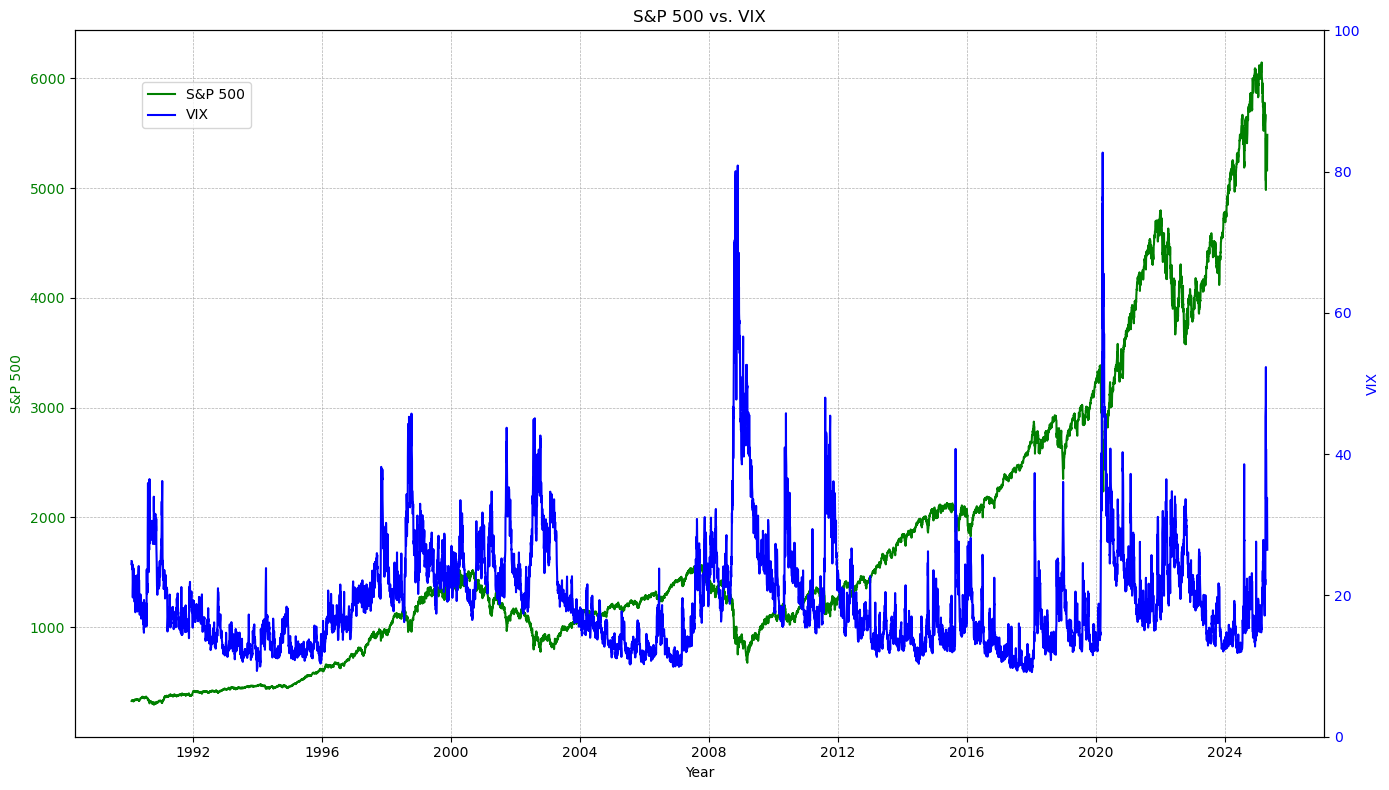

In [15]:
# Line plot of S&P 500 and VIX over time
fig, ax1 = plt.subplots(figsize=(14, 8))

filtered_df = df[(df.index >= START_DATE) & (df.index <= END_DATE)]

# S&P 500 plot
ax1.plot(filtered_df.index, filtered_df['SP500_Close'], color='green', label='S&P 500')
ax1.set_xlabel('Year')
ax1.set_ylabel('S&P 500', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Secondary Y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df['VIX_Close'], color='blue', label='VIX')
ax2.set_ylabel('VIX', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 100)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('S&P 500 vs. VIX')
plt.tight_layout()
plt.show()

The chart visualizes VIX and S&P 500 values over time. Sharp increases in VIX are typically accompanied by declines in the S&P 500. At VIX peaks, most of the S&P 500 drawdown has usually already materialized.

In [18]:
# Spearman correlation between S&P 500 and VIX
spearman_corr = monthly_df['SP500_Close'].corr(
    monthly_df['VIX_Close'], method='spearman'
)
print(f"Spearman correlation between S&P 500 and VIX: {spearman_corr:.4f}")

Spearman correlation between S&P 500 and VIX: -0.0479


In [20]:
# Ensure Date is index and sorted
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)
sp500 = sp500.sort_index()

vix['Date'] = pd.to_datetime(vix['Date'])
vix.set_index('Date', inplace=True)
vix = vix.sort_index()

In [22]:
# Set of available trading dates
available_dates = set(sp500.index)

In [24]:
# Find next Monday with available market data
def find_next_monday_with_data(date):
    max_lookahead = 7
    for i in range(max_lookahead):
        candidate = date + timedelta(days=i)
        if candidate.weekday() == 0 and candidate in available_dates:
            return candidate
    return None

In [26]:
# Price lookup dictionary
sp500_prices = sp500['SP500_Close'].to_dict()

In [28]:
# Collect results
results = []

for current_date, row in sp500.iterrows():
    raw_future_date = current_date + timedelta(days=1825)
    future_date = raw_future_date

    if future_date not in available_dates:
        future_date = find_next_monday_with_data(raw_future_date)

    if future_date and current_date in vix.index:
        current_price = row['SP500_Close']
        future_price = sp500_prices.get(future_date, np.nan)

        if not np.isnan(future_price):
            rate_of_return = (future_price - current_price) / current_price
            vix_value = vix.loc[current_date, 'VIX_Close']

            results.append({
                'Date': current_date,
                'VIX_Close': vix_value,
                'Return_5y': rate_of_return
            })

results_df = pd.DataFrame(results)

In [30]:
# Spearman correlation between VIX level and 5-year return
correlation = results_df['VIX_Close'].corr(
    results_df['Return_5y'], method='spearman'
)

print(
    f"Spearman correlation between VIX level and 5-year return: {correlation:.4f}"
)

Spearman correlation between VIX level and 5-year return: -0.1799


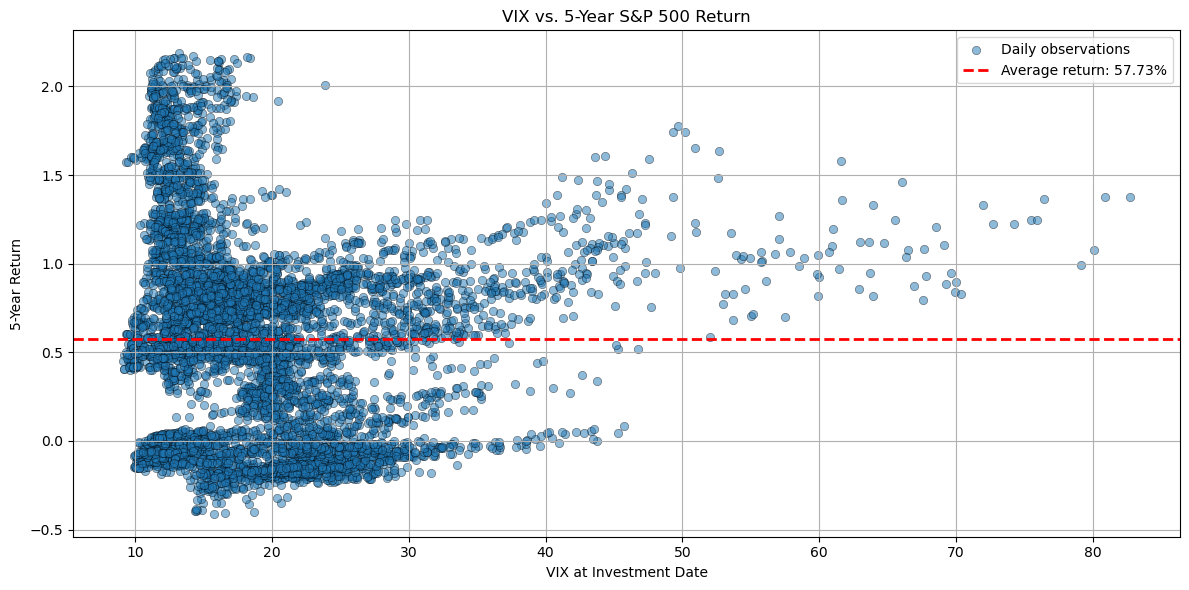

In [32]:
# Mean 5-year return
mean_return = results_df['Return_5y'].mean()

# Scatter plot: VIX vs 5-year return
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=results_df,
    x='VIX_Close',
    y='Return_5y',
    alpha=0.5,
    edgecolor='k',
    label='Daily observations'
)

plt.axhline(
    mean_return,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Average return: {mean_return:.2%}'
)

plt.title('VIX vs. 5-Year S&P 500 Return')
plt.xlabel('VIX at Investment Date')
plt.ylabel('5-Year Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Round VIX for stability
vix_levels = sorted(results_df['VIX_Close'].round(1).unique())

# Find minimum VIX level where all returns exceed the average
safe_vix_level = None

for threshold in vix_levels:
    subset = results_df[results_df['VIX_Close'] >= threshold]
    if not subset.empty and (subset['Return_5y'] > mean_return).all():
        safe_vix_level = threshold
        break

if safe_vix_level:
    print(
        f"For VIX >= {safe_vix_level}, 5-year return always abouve the average ({mean_return:.2%})"
    )
else:
    print(
        "Not found."
    )

For VIX >= 46.8, 5-year return always abouve the average (57.73%)


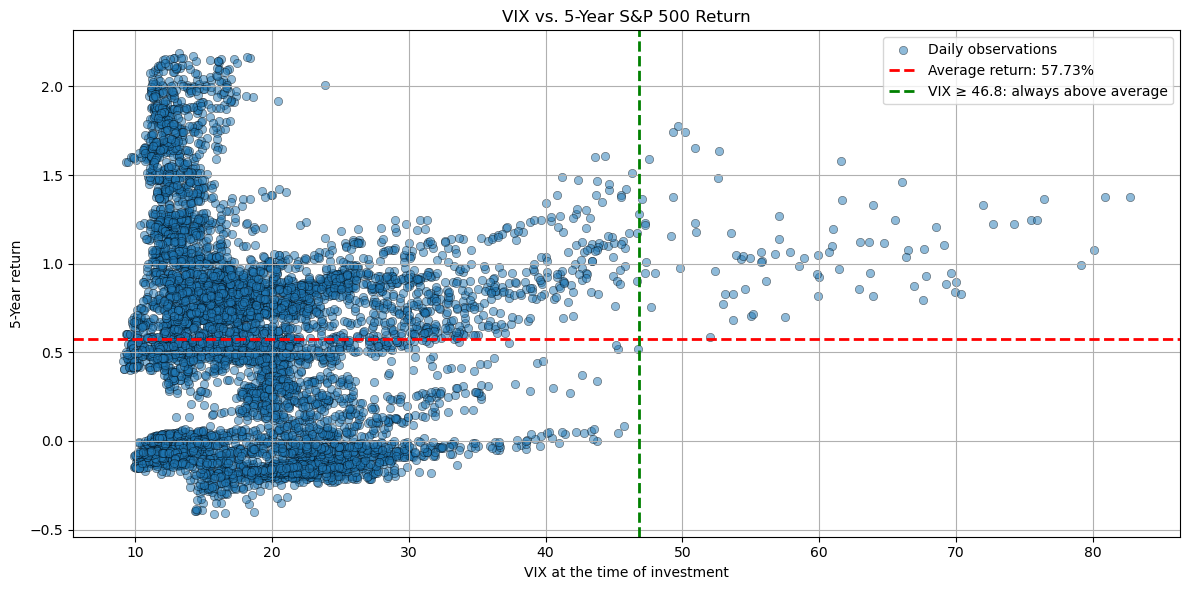

In [44]:
# Create scatter plot
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=results_df,
    x='VIX_Close',
    y='Return_5y',
    alpha=0.5,
    edgecolor='k',
    label='Daily observations'
)

# Horizontal line: average return
plt.axhline(
    mean_return,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Average return: {mean_return:.2%}'
)

# Vertical line: safe VIX level
if safe_vix_level:
    plt.axvline(
        safe_vix_level,
        color='green',
        linestyle='--',
        linewidth=2,
        label=f'VIX ≥ {safe_vix_level:.1f}: always above average'
    )

# Labels and layout
plt.title('VIX vs. 5-Year S&P 500 Return')
plt.xlabel('VIX at the time of investment')
plt.ylabel('5-Year return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Count number of days with VIX >= safe level
count_high_vix = (vix['VIX_Close'] >= safe_vix_level).sum()
print(f"Number of days with VIX ≥ 46.8: {count_high_vix}")

Number of days with VIX ≥ 46.8: 92


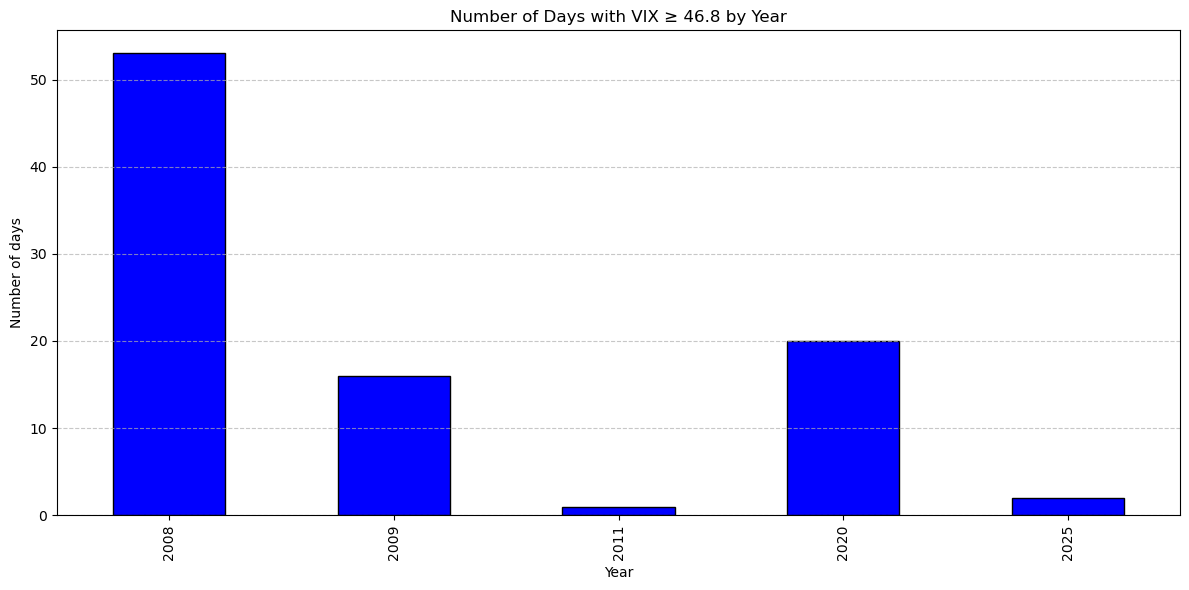

In [49]:
# Filter days with high VIX
high_vix = vix[vix['VIX_Close'] >= safe_vix_level].copy()

# Add year column
high_vix['Year'] = high_vix.index.year

# Group by year and count days
vix_counts_by_year = high_vix.groupby('Year').size()

# Bar chart
plt.figure(figsize=(12, 6))
vix_counts_by_year.plot(kind='bar', color='blue', edgecolor='black')

# Labels
plt.title('Number of Days with VIX ≥ 46.8 by Year')
plt.xlabel('Year')
plt.ylabel('Number of days')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
# Regular strategy – monthly investments for 5 years, sell at the end
def simulate_regular_portfolio(data, START_DATE):
    total_invested = 0
    total_units = 0
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)

    for i in range(INVESTMENT_HORIZON_MONTHS):
        date = START_DATE + pd.DateOffset(months=i)
        if date in data.index:
            price = data.loc[date]['SP500_Close']
            units = MONTHLY_SAVING / price
            total_units += units
            total_invested += MONTHLY_SAVING

    if END_DATE in data.index:
        final_price = data.loc[END_DATE]['SP500_Close']
        portfolio_value = total_units * final_price
        return (portfolio_value - total_invested) / total_invested * 100

    return None

In [53]:
# VIX-based strategies – percentile thresholds
# Calculate percentiles
percentiles = [80, 85, 90, 95]
vix_percentile_values = np.percentile(vix['VIX_Close'].dropna(), percentiles)

# Print percentile values
for p, val in zip(percentiles, vix_percentile_values):
    print(f"{p}. percentyl VIX = {val:.2f}")

80. percentyl VIX = 24.31
85. percentyl VIX = 26.06
90. percentyl VIX = 28.71
95. percentyl VIX = 33.20


In [55]:
# VIX strategy – invest only when VIX exceeds threshold, hold until horizon end
def simulate_vix_strategy_portfolio(data, vix_cutoff, START_DATE):
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)
    current_year = START_DATE.year
    last_investment_year = None

    savings = 0
    total_units = 0
    total_invested = 0

    for date in data.loc[START_DATE:END_DATE].index:
        row = data.loc[date]
        savings += MONTHLY_SAVING

        if last_investment_year != date.year:
            if row['VIX_Close'] > vix_cutoff:
                price = row['SP500_Close']
                units = savings / price
                total_units += units
                total_invested += savings
                savings = 0
                last_investment_year = date.year

    # If no investments were made
    if total_invested == 0:
        return None

    # Portfolio value at the end of the horizon
    if END_DATE in data.index:
        final_price = data.loc[END_DATE]['SP500_Close']
        portfolio_value = total_units * final_price
        return (portfolio_value - total_invested) / total_invested * 100

    return None

In [59]:
# Run simulations for multiple start dates
start_dates = monthly_df.index[:-INVESTMENT_HORIZON_MONTHS]

regular_results = []
vix_results = {p: [] for p in PERCENTILES_TO_TEST}

for START_DATE in start_dates:
    r = simulate_regular_portfolio(monthly_df, START_DATE)
    if r is not None:
        regular_results.append(r)

    for p in PERCENTILES_TO_TEST:
        cutoff = monthly_df['VIX_Close'].quantile(p / 100)
        vr = simulate_vix_strategy_portfolio(monthly_df, cutoff, START_DATE)
        if vr is not None:
            vix_results[p].append(vr)

In [63]:
# Results: mean return and standard deviation
regular_mean = np.mean(regular_results)
regular_std = np.std(regular_results)

vix_means = {p: np.mean(vix_results[p]) for p in PERCENTILES_TO_TEST}
vix_stds = {p: np.std(vix_results[p]) for p in PERCENTILES_TO_TEST}

print(f"Regular: Mean = {regular_mean:.2f}%, std deviation = {regular_std:.2f}%")
for p in PERCENTILES_TO_TEST:
    print(f"VIX > {p}%: Mean = {vix_means[p]:.2f}%, std deviation = {vix_stds[p]:.2f}%")

Regular: Mean = 28.19%, std deviation = 27.47%
VIX > 80%: Mean = 25.42%, std deviation = 26.23%
VIX > 85%: Mean = 26.79%, std deviation = 26.90%
VIX > 90%: Mean = 29.82%, std deviation = 28.51%
VIX > 95%: Mean = 31.04%, std deviation = 28.74%


In [65]:
# Count cases in defined return ranges
def count_cases_in_ranges(results, ranges):
    counts = {}
    for r in ranges:
        counts[r] = np.sum(
            (np.array(results) >= r[0]) & (np.array(results) < r[1])
        )
    return counts


# Define return ranges
ranges = [(50, 60), (60, 70), (80, 200)]

# Count cases for regular strategy
regular_counts = count_cases_in_ranges(regular_results, ranges)

# Count cases for VIX strategies
vix_counts = {
    p: count_cases_in_ranges(vix_results[p], ranges)
    for p in PERCENTILES_TO_TEST
}

print("Count cases for VIX strategies:")
for r in ranges:
    print(f"Return {r[0]}% - {r[1]}%: {regular_counts[r]} cases")

for p in PERCENTILES_TO_TEST:
    print(f"\nCount cases in defined return ranges of VIX > {p}%:")
    for r in ranges:
        print(f"Return {r[0]}% - {r[1]}%: {vix_counts[p][r]} cases")

Count cases for VIX strategies:
Return 50% - 60%: 25 cases
Return 60% - 70%: 9 cases
Return 80% - 200%: 17 cases

Count cases in defined return ranges of VIX > 80%:
Return 50% - 60%: 22 cases
Return 60% - 70%: 29 cases
Return 80% - 200%: 5 cases

Count cases in defined return ranges of VIX > 85%:
Return 50% - 60%: 24 cases
Return 60% - 70%: 19 cases
Return 80% - 200%: 5 cases

Count cases in defined return ranges of VIX > 90%:
Return 50% - 60%: 30 cases
Return 60% - 70%: 25 cases
Return 80% - 200%: 4 cases

Count cases in defined return ranges of VIX > 95%:
Return 50% - 60%: 29 cases
Return 60% - 70%: 11 cases
Return 80% - 200%: 24 cases


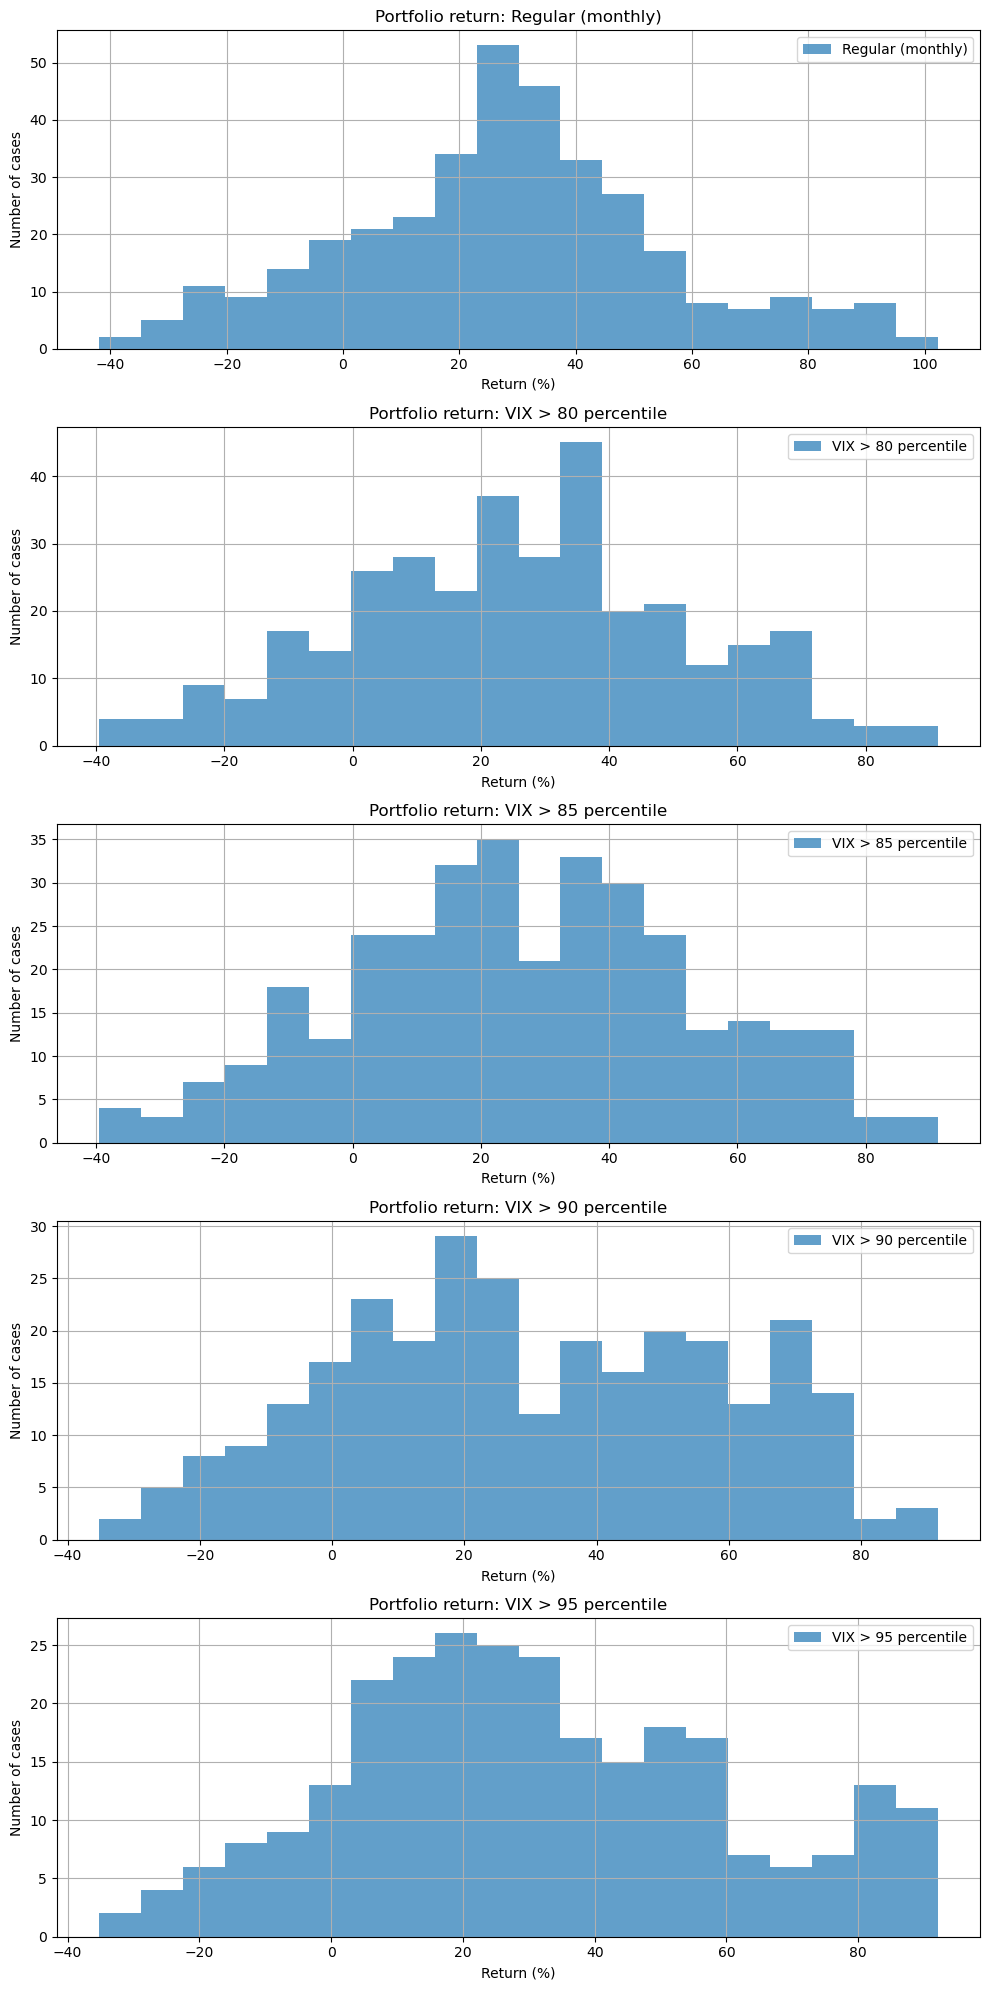

In [67]:
# Histogram for simulation results
def plot_histogram(results, label, ax):
    ax.hist(results, bins=20, alpha=0.7, label=label)
    ax.set_title(f'Portfolio return: {label}')
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Number of cases')
    ax.grid(True)
    ax.legend()


# Create histograms for each strategy
fig, axs = plt.subplots(
    len(PERCENTILES_TO_TEST) + 1, 1, figsize=(10, 20)
)

plot_histogram(regular_results, 'Regular (monthly)', axs[0])

for i, p in enumerate(PERCENTILES_TO_TEST):
    plot_histogram(
        vix_results[p],
        f'VIX > {p} percentile',
        axs[i + 1]
    )

plt.tight_layout()
plt.show()

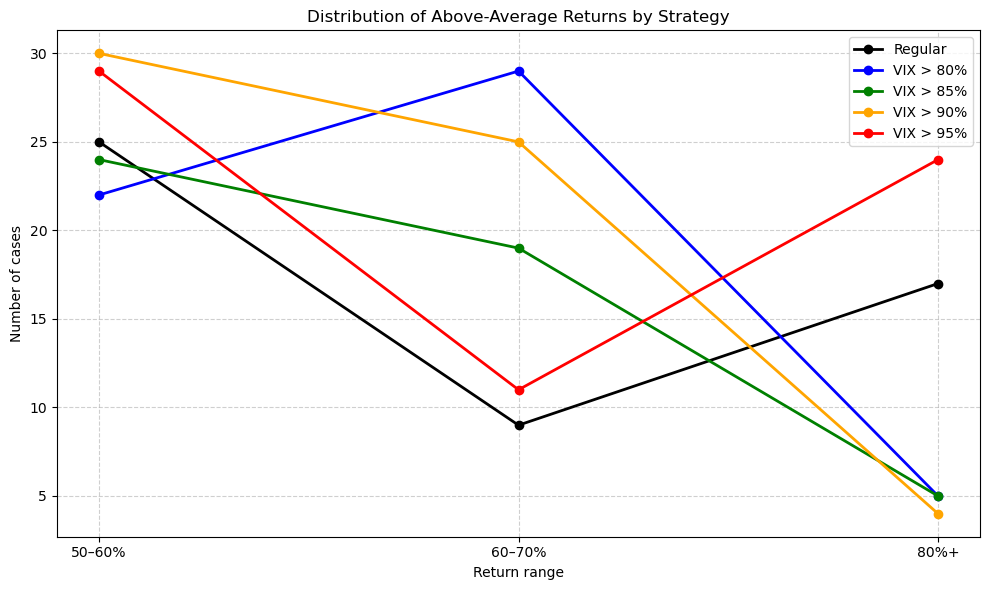

In [69]:
# Return range labels
range_labels = ['50–60%', '60–70%', '80%+']

# Strategy labels
strategies = ['Regular'] + [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]

all_data = (
    [[regular_counts[r] for r in ranges]] +
    [[vix_counts[p][r] for r in ranges] for p in PERCENTILES_TO_TEST]
)

plt.figure(figsize=(10, 6))
colors = ['black', 'blue', 'green', 'orange', 'red']

for i, data in enumerate(all_data):
    plt.plot(
        range_labels,
        data,
        marker='o',
        linewidth=2,
        color=colors[i],
        label=strategies[i]
    )

plt.xlabel('Return range')
plt.ylabel('Number of cases')
plt.title('Distribution of Above-Average Returns by Strategy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

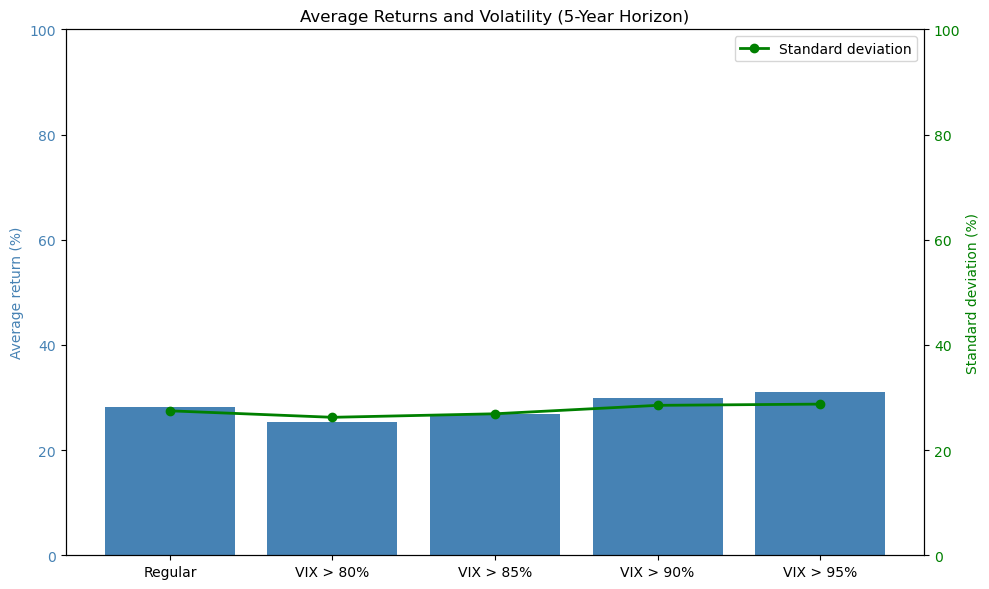

In [71]:
# Mean returns and standard deviation chart
means = [regular_mean] + [vix_means[p] for p in PERCENTILES_TO_TEST]
stds = [regular_std] + [vix_stds[p] for p in PERCENTILES_TO_TEST]
labels = ['Regular'] + [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(labels, means, color='steelblue')
ax1.set_ylabel('Average return (%)', color='steelblue')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.set_ylabel('Standard deviation (%)', color='green')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', labelcolor='green')

ax2.plot(
    labels,
    stds,
    color='green',
    marker='o',
    linewidth=2,
    label='Standard deviation'
)

plt.title('Average Returns and Volatility (5-Year Horizon)')
plt.xticks(rotation=45)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [73]:
# Count number of investments
def count_vix_investments(data, vix_cutoff, START_DATE):
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)
    current_year = START_DATE.year
    last_investment_year = None

    count = 0
    savings = 0

    for date in data.loc[START_DATE:END_DATE].index:
        row = data.loc[date]
        savings += MONTHLY_SAVING

        if last_investment_year != date.year:
            if row['VIX_Close'] > vix_cutoff:
                count += 1
                savings = 0
                last_investment_year = date.year

    return count

In [75]:
# Collect the number of investments
investment_counts = {p: [] for p in PERCENTILES_TO_TEST}
for START_DATE in start_dates:
    for p in PERCENTILES_TO_TEST:
        cutoff = monthly_df['VIX_Close'].quantile(p / 100)
        count = count_vix_investments(monthly_df, cutoff, START_DATE)
        investment_counts[p].append(count)

In [79]:
# Average number of investments
print("\nAverage number of investments (in 5 years):")
for p in PERCENTILES_TO_TEST:
    avg_inv = np.mean(investment_counts[p])
    print(f"VIX > {p}%: {avg_inv:.2f} times")


Average number of investments (in 5 years):
VIX > 80%: 2.84 times
VIX > 85%: 2.61 times
VIX > 90%: 2.21 times
VIX > 95%: 1.78 times


In [81]:
# Categorize number of investments
def categorize_investments(counts):
    bins = {
        '0': 0,
        '1': 0,
        '2': 0,
        '3': 0,
        '4': 0,
        '5+': 0
    }

    for c in counts:
        if c == 0:
            bins['0'] += 1
        elif c == 1:
            bins['1'] += 1
        elif c == 2:
            bins['2'] += 1
        elif c == 3:
            bins['3'] += 1
        elif c == 4:
            bins['4'] += 1
        else:
            bins['5+'] += 1

    return bins


# Collect data for each strategy
investment_distribution = {
    p: categorize_investments(investment_counts[p])
    for p in PERCENTILES_TO_TEST
}

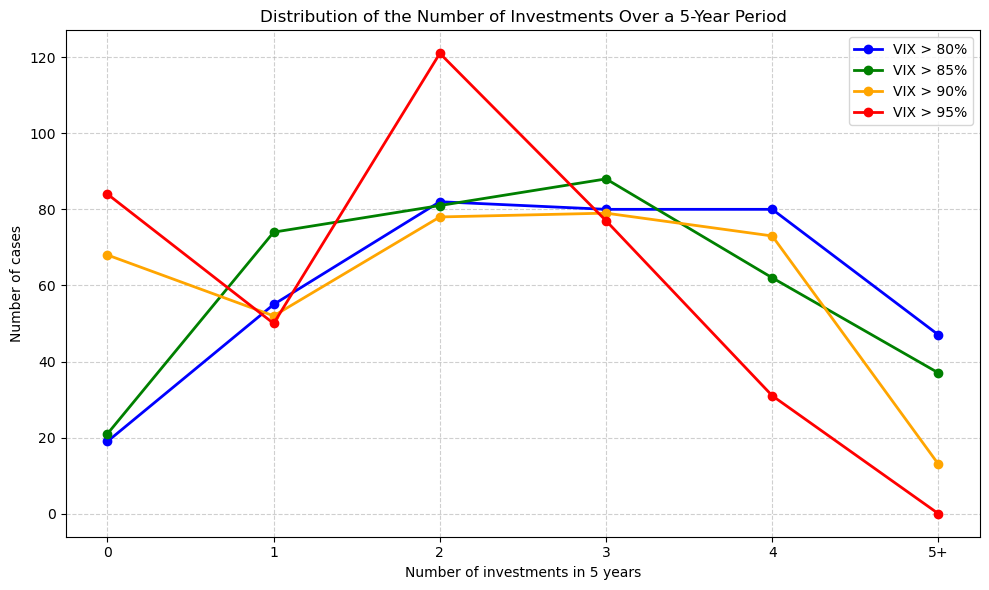

In [83]:
categories = ['0', '1', '2', '3', '4', '5+']
strategies = [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))

# Plot a line for each strategy
for i, p in enumerate(PERCENTILES_TO_TEST):
    values = [investment_distribution[p][cat] for cat in categories]
    plt.plot(
        categories,
        values,
        marker='o',
        label=strategies[i],
        linewidth=2,
        color=colors[i]
    )

plt.title('Distribution of the Number of Investments Over a 5-Year Period')
plt.xlabel('Number of investments in 5 years')
plt.ylabel('Number of cases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

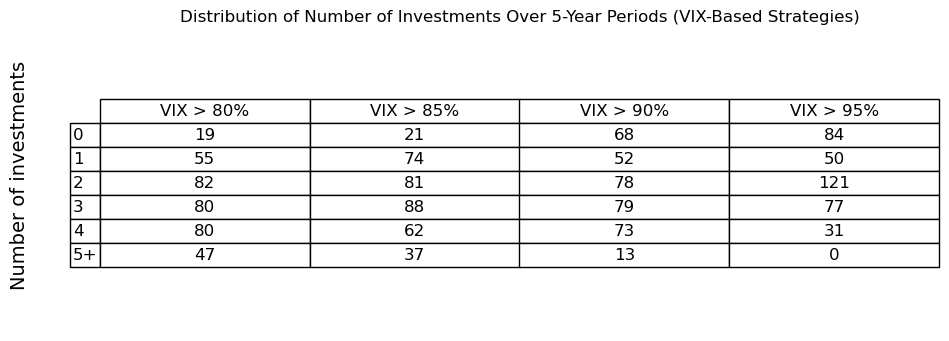

In [95]:
investment_table = pd.DataFrame({
    f'VIX > {p}%': [investment_distribution[p][cat] for cat in ['0', '1', '2', '3', '4', '5+']]
    for p in PERCENTILES_TO_TEST
}, index=['0', '1', '2', '3', '4', '5+'])

# Create figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

# Draw table
table = ax.table(
    cellText=investment_table.values,
    rowLabels=investment_table.index,
    colLabels=investment_table.columns,
    cellLoc='center',
    loc='center'
)

# Adjust font size and scale
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Add vertical label on the left using fig.text
fig.text(
    0.05, 0.5,  # x, y in figure coordinates
    'Number of investments',
    va='center',
    ha='center',
    rotation=90,
    fontsize=14
)

# Title above the table
plt.title(
    'Distribution of Number of Investments Over 5-Year Periods (VIX-Based Strategies)',
    pad=10
)

# Adjust margins to make space for vertical label
plt.subplots_adjust(left=0.2, top=0.85)

plt.show()

In [101]:
# Calculate drawdown for risk estimation
def calculate_drawdown(portfolio_values):
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    return max_drawdown


# Calculate drawdown for the regular strategy
regular_drawdowns = []
for START_DATE in start_dates:
    portfolio_values = []

    for i in range(INVESTMENT_HORIZON_MONTHS):
        date = START_DATE + pd.DateOffset(months=i)
        if date in monthly_df.index:
            portfolio_values.append(
                monthly_df.loc[date]['SP500_Close']
            )

    if portfolio_values:
        regular_drawdowns.append(
            calculate_drawdown(np.array(portfolio_values))
        )


# Calculate drawdown for VIX strategies
vix_drawdowns = {p: [] for p in PERCENTILES_TO_TEST}

for p in PERCENTILES_TO_TEST:
    for START_DATE in start_dates:
        portfolio_values = []
        savings = 0

        for i in range(INVESTMENT_HORIZON_MONTHS):
            date = START_DATE + pd.DateOffset(months=i)
            if date in monthly_df.index:
                row = monthly_df.loc[date]
                savings += MONTHLY_SAVING

                if row['VIX_Close'] > monthly_df['VIX_Close'].quantile(p / 100):
                    portfolio_values.append(row['SP500_Close'])
                    savings = 0

        if portfolio_values:
            vix_drawdowns[p].append(
                calculate_drawdown(np.array(portfolio_values))
            )


# Display drawdown results
print("Drawdown of regular strategy:")
print(
    f"Mean drawdown: {np.mean(regular_drawdowns):.2%}, "
    f"Max drawdown: {np.min(regular_drawdowns):.2%}"
)

for p in PERCENTILES_TO_TEST:
    print(f"\nDrawdown for VIX strategy > {p}%:")
    print(
        f"Mean drawdown: {np.mean(vix_drawdowns[p]):.2%}, "
        f"Max drawdown: {np.min(vix_drawdowns[p]):.2%}"
    )

Drawdown of regular strategy:
Mean drawdown: -23.50%, Max drawdown: -52.56%

Drawdown for VIX strategy > 80%:
Mean drawdown: -20.16%, Max drawdown: -46.68%

Drawdown for VIX strategy > 85%:
Mean drawdown: -18.89%, Max drawdown: -46.68%

Drawdown for VIX strategy > 90%:
Mean drawdown: -17.39%, Max drawdown: -38.00%

Drawdown for VIX strategy > 95%:
Mean drawdown: -12.73%, Max drawdown: -36.98%
